# Demo - Siren

In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root, local
root = here(project_files=[".root"])
local = here(project_files=[".local"])

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

In [2]:
from pathlib import Path
import argparse
import wandb
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

# # Ensure TF does not see GPU and grab all GPU memory.
# import tensorflow as tf
# tf.config.set_visible_devices([], device_type='GPU')

# os.environ["JAX_PLATFORM_NAME"] = "CPU"
# # ENSURE JAX DOESNT PREALLOCATE
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = str(False)

import jax
import jax.random as jrandom
import jax.numpy as jnp
import equinox as eqx
from ml4ssh._src.data import make_mini_batcher
from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian

# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from model import add_model_args, get_model
from loss import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizer import add_optimizer_args, get_optimizer
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics

%matplotlib inline
%load_ext autoreload
%autoreload 2

2022-06-02 13:55:02.456472: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


### Argumentsget_data_args

In [48]:
parser = argparse.ArgumentParser()

# logger
parser = add_logger_args(parser)

# data
parser = get_data_args(parser)

# preprocessing, feature transform, split
parser = add_preprocess_args(parser)
parser = add_feature_args(parser)
parser = add_split_args(parser)

# model, optimizer, loss
parser = add_model_args(parser)
parser = add_optimizer_args(parser)
parser = add_loss_args(parser)

# postprocessing, metrics
parser = add_postprocess_args(parser)
parser = add_eval_args(parser)

# parse args
args = parser.parse_args([])

# # jeanzay specific
# args.train_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/train/"
# args.ref_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/ref/"
# args.test_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/test/"
# args.log_dir = "/gpfswork/rech/cli/uvo53rl/logs"

# training args
args.batch_size = 4096
args.n_epochs = 1

# model args
args.model = "siren"
args.activation = "sine"
args.julian_time = True

# smoke test
args.smoke_test = True

# logging stuff
args.wandb_mode = "disabled"
args.wandb_resume = True
# ige/nerf4ssh/kx2nr6qb
args.id = None # "mikf2n1v" # "2uuq7tks" "kx2nr6qb"
# args.entity = "ige"


In [49]:
args.model

'siren'

### Logger


In [50]:
# init wandb logger
wandb.init(
    id=args.id,
    config=args,
    mode=args.wandb_mode,
    project=args.project,
    entity=args.entity,
    dir=args.log_dir,
    resume=args.wandb_resume
)

### Load Data

In [51]:
%%time

# load data
data = load_data(args)

100%|██████████| 6/6 [00:00<00:00, 60.14it/s]


CPU times: user 300 ms, sys: 640 ms, total: 940 ms
Wall time: 946 ms


In [52]:
# preprocess data
data = preprocess_data(data, args)

In [53]:
# feature transformation
data, scaler = feature_transform(data, args)

Juliennnn!
2457723.546630142 2458149.4552697684


In [54]:
juliantime = data["time"]

In [47]:
njuliantime = data["time"]


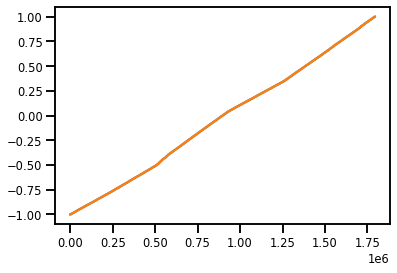

In [56]:

plt.plot(njuliantime)
plt.plot(juliantime)

In [34]:



# split data
xtrain, ytrain, xvalid, yvalid = split_data(data, args)

args.in_dim = xtrain.shape[-1]
args.n_train = xtrain.shape[0]
args.n_valid = xvalid.shape[0]

wandb.config.update(
    {
        "in_dim": args.in_dim,
        "n_train": args.n_train,
        "n_valid": args.n_valid,
    }
)

In [35]:
data[["longitude", "latitude", "time"]].head()

,longitude,latitude,time
0,0.633663,-0.998266,-1.0
1,0.632683,-0.994338,-1.0
2,0.631703,-0.990410,-1.0
3,0.630723,-0.986482,-1.0
4,0.629742,-0.982554,-1.0


### Model

In [8]:
%%time


# model
model = get_model(args)

# optimizer
optimizer = get_optimizer(args)

# loss
make_step, val_step = get_loss_fn(args)

# init optimizer
opt_state = optimizer.init(model)

CPU times: user 1.51 s, sys: 16 ms, total: 1.53 s
Wall time: 1.55 s


In [9]:
n_steps_per_epoch = args.n_train / args.batch_size
steps = int(n_steps_per_epoch * args.n_epochs) if not args.smoke_test else 500


wandb.config.update(
    {
        "steps": steps,
        "n_steps_per_epoch": n_steps_per_epoch,
    }
)

In [10]:
int((args.n_train / args.batch_size) * 1)

786

### Training

In [11]:
train_ds = make_mini_batcher(xtrain, ytrain, args.batch_size, 5, shuffle=True)
valid_ds = make_mini_batcher(xvalid, yvalid, args.batch_size, 5, shuffle=False)


losses = {} 
losses["train"] = []
losses["valid"] = []


with tqdm.trange(steps) as pbar:
    for step in pbar:
        
        ix, iy = next(train_ds)
        loss, grads = make_step(model, jnp.asarray(ix), jnp.asarray(iy))
        
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        
        losses["train"].append(loss)
        wandb.log({"train_loss": loss}, step=step)
        ix, iy = next(valid_ds)
        # validation step
        vloss = val_step(model, jnp.asarray(ix), jnp.asarray(iy))
        losses["valid"].append(vloss)
        
        
        wandb.log({"val_loss": vloss}, step=step)
        
        if step % 10 == 0:
            pbar.set_description(f"Step: {step:_} | Train Loss: {loss:.3e} | Valid Loss: {vloss:.3e}")
            


2022-06-01 22:50:51.182815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-01 22:50:51.182922: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
Step: 490 | Train Loss: 9.411e-02 | Valid Loss: 1.227e-01: 100%|██████████| 500/500 [02:16<00:00,  3.67it/s]


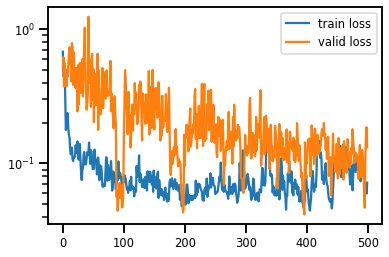

In [12]:
fig, ax = plt.subplots()
ax.plot(losses["train"], label="train loss")
ax.plot(losses["valid"], label="valid loss")
plt.yscale("log")
plt.legend()
plt.show()

### Save models

In [12]:
# objects
path_model = Path(wandb.run.dir).joinpath("model.pickle")
path_scaler = Path(wandb.run.dir).joinpath("scaler.pickle")

# models to save
save_object(model, path_model)
save_object(scaler, path_scaler)

# save with wandb
wandb.save(str(path_model), policy="now")
wandb.save(str(path_scaler), policy="now")

### Load Models (Optional)

In [13]:
# # if args.server == "jz":
# # get id (from this run or a run you can set)
# run_id = wandb.run.id

# # initialize api
# api = wandb.Api()

# # get run
# run = api.run(f"{args.entity}/{args.project}/{run_id}")

# # download the files
# files = [
#     "scaler.pickle", 
#     "model.pickle"
# ]

# for ifile in files:
    
#     run.file(ifile).download(replace=True)

In [14]:
# model = load_object("./model.pickle")
# scaler = load_object("./scaler.pickle")

### PostProcessing

In [15]:
df_grid = generate_eval_data(args)

df_grid.describe()

,longitude,latitude,vtime
count,2664.000000,2664.000000,2664.000000
mean,300.000000,38.000000,213.500000
std,3.416292,3.416292,106.820098
min,295.000000,33.000000,31.000000
25%,297.000000,35.000000,121.000000
50%,300.000000,38.000000,213.500000
75%,303.000000,41.000000,306.000000
max,305.000000,43.000000,396.000000


In [16]:
df_pred = feature_transform(df_grid.copy(), args, scaler=scaler)
df_pred.describe(), df_grid.describe()

(          longitude     latitude         time        vtime
 count  2.664000e+03  2664.000000  2664.000000  2664.000000
 mean  -2.666668e-07     0.000003     0.002343   213.500000
 std    2.277529e-01     0.227754     0.501610   106.820098
 min   -3.333338e-01    -0.333332    -0.854648    31.000000
 25%   -2.000004e-01    -0.199998    -0.432022   121.000000
 50%   -2.666668e-07     0.000003     0.002343   213.500000
 75%    1.999999e-01     0.200003     0.436709   306.000000
 max    3.333333e-01     0.333337     0.859335   396.000000,
          longitude     latitude        vtime
 count  2664.000000  2664.000000  2664.000000
 mean    300.000000    38.000000   213.500000
 std       3.416292     3.416292   106.820098
 min     295.000000    33.000000    31.000000
 25%     297.000000    35.000000   121.000000
 50%     300.000000    38.000000   213.500000
 75%     303.000000    41.000000   306.000000
 max     305.000000    43.000000   396.000000)

In [17]:
df_pred = jnp.asarray(df_pred[df_pred.columns.difference(["time"])].values)

In [18]:
wandb.config.update(
    {
        "n_test": df_pred.shape[0],
    }
)

### Predictions


In [19]:
@jax.jit
def pred_step(model, data):
    return jax.vmap(model)(data)

In [20]:
from ml4ssh._src.model_utils import batch_predict
from functools import partial
import time

In [21]:
args.eval_batch_size

10000

In [22]:


fn = partial(pred_step, model)

t0 = time.time()
df_grid["pred"] = batch_predict(
    df_pred, 
    fn, 
    100, #args.eval_batch_size, 
    jnp.asarray
)
t1 = time.time() - t0

100%|██████████| 27/27 [00:00<00:00, 46.36it/s]


In [23]:
# wandb.config.update(
#     {
#         "time_predict_batches": t1,
#     }
# )

In [24]:
ds_oi = postprocess_data(df_grid, args)

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/miss

In [25]:
ds_oi

<xarray.Dataset>
Dimensions:    (latitude: 6, longitude: 6, time: 74)
Coordinates:
  * latitude   (latitude) float64 33.0 35.0 37.0 39.0 41.0 43.0
  * longitude  (longitude) float64 295.0 297.0 299.0 301.0 303.0 305.0
  * time       (time) datetime64[ns] 2017-01-01 2017-01-06 ... 2018-01-01
Data variables:
    index      (latitude, longitude, time) int64 0 1 2 3 ... 2660 2661 2662 2663
    vtime      (latitude, longitude, time) float64 31.0 36.0 ... 391.0 396.0
    pred       (latitude, longitude, time) float32 0.09012 0.09249 ... 0.15
    ssh        (latitude, longitude, time) float64 0.6898 0.6922 ... -0.02144

In [26]:
%%time

rmse_metrics = get_rmse_metrics(ds_oi, args)

wandb.log(
    {
        "model_rmse_mean": rmse_metrics[0],
        "model_rmse_std": rmse_metrics[1],
        "model_nrmse_mean": rmse_metrics[2],
        "model_nrmse_std": rmse_metrics[3],
    }
)

print(rmse_metrics)

RMSE (Mean): 0.268
RMSE (Std): 0.074
NRMSE (Mean): 0.553
NRMSE (Std): 0.199
CPU times: user 432 ms, sys: 8 ms, total: 440 ms
Wall time: 447 ms


In [27]:
psd_metrics = get_psd_metrics(ds_oi, args)
print(psd_metrics)

Resolved Scale: 562766771201742.000 (km)


### Figures

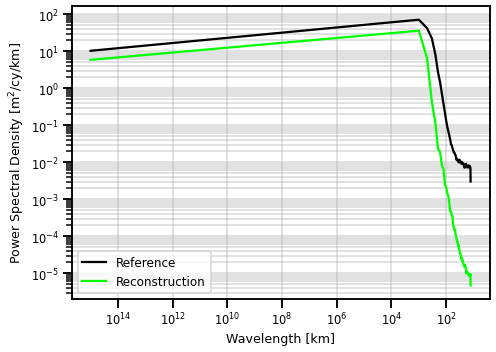

In [28]:
fig, ax = plot_psd_spectrum(
    psd_metrics.psd_study, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber
)


wandb.log(
    {
        "model_psd_spectrum": wandb.Image(fig),
    }
)

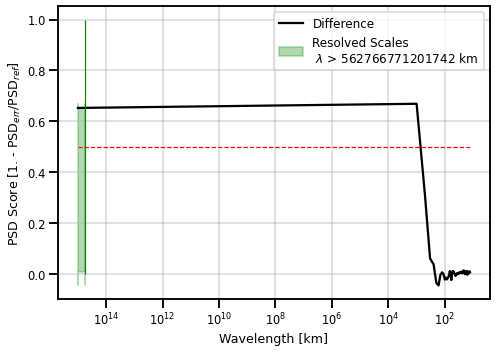

In [29]:
fig, ax = plot_psd_score(
    psd_metrics.psd_diff, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber, 
    psd_metrics.resolved_scale)

wandb.log(
    {
        "model_psd_score": wandb.Image(fig),
    }
)

### Movies

In [24]:
save_path = wandb.run.dir #Path(root).joinpath("experiments/dc_2021b")

In [25]:
# import hvplot.xarray


# ds_oi.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="viridis")

In [26]:
create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Movie created at movie_pred.mp4
GIF created at wandb/run-20220601_174733-kx2nr6qb/files/movie_pred.gif


![](wandb/run-20220601_174733-kx2nr6qb/files/movie_pred.gif)

In [ ]:
if args.smoke_test:
    create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)
else:
    create_movie(ds_oi.ssh, f"pred", "time", cmap="viridis", file_path=save_path)


/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/365 [00:00<?, ?it/s]

Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 170, in check_status
    status_response = self._interface.communicate_stop_status()
  File "/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/wandb/sdk/interface/interface.py", line 127, in communicate_stop_status
    resp = self._communicate_stop_status(status)
  File "/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/wandb/sdk/interface/interface_shared.py", line 395, in _communicate_stop_status
    resp = self._communicate(req, local=True)
  File "/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/pytho

In [27]:
wandb.log(
    {
        "predictions_gif": wandb.Image(f"{save_path}/movie_pred.gif"),
    }
)

### Gradients

In [45]:
ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")

In [ ]:
# ds_oi.ssh_grad.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="Spectral_r")

In [46]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_grad.isel(time=slice(50,60)), f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_grad, f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)

In [47]:
# wandb.log(
#     {
#         "predictions_grad_gif": wandb.Image(f"{save_path}/movie_pred_grad.gif"),
#     }
# )

### Laplacian

In [49]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")

In [ ]:
# ds_oi.ssh_lap.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="RdBu_r")

In [36]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_lap.isel(time=slice(50,60)), f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_lap, f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)


/gpfswork/rech/cli/uvo53rl/.conda/envs/jax_gpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/gpfswork/rech/cli/uvo53rl/.conda/envs/jax_gpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Movie created at movie_pred_lap.mp4
GIF created at movie_pred_lap.gif


In [50]:
# wandb.log(
#     {
#         "predictions_laplacian_gif": wandb.Image(f"{save_path}/movie_pred_lap.gif"),
#     }
# )

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/movie_pred_lap.gif'

In [62]:

t = jnp.ones((5,4))
t1, t2 = jnp.array_split(t,2, axis=1) 
t.shape, t1.shape, t2.shape

((5, 4), (5, 2), (5, 2))